In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, PersistenceImage 
from gtda.plotting import plot_point_cloud
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from hausdorff import hausdorff_distance
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from sklearn.decomposition import KernelPCA
import plotly.io as pio
from gtda.plotting import plot_diagram
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import glob

%matplotlib inline

# Load data

In [2]:
# Load all features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [3]:
subject_list = ["293", "294", "298"]
label_list = [1, 2, 3, 4, 5, 7]

In [6]:
persistence_diagrams = {}
reshaped_persistence_diagrams = {}

for subject in subject_list:
    persistence_diagrams[subject] = {}
    reshaped_persistence_diagrams[subject] = {}
    extended_persistence_diagrams[subject] = {}
    most_representative_diagrams[subject] = {}

    
    for data_type in ["EEG", "EMG"]:
        persistence_diagrams[subject][data_type]  = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
                allow_pickle=True).item() # .item() to convert the dtype to dict again

    
        reshaped_persistence_diagrams[subject][data_type] = {}

        for label in label_list:
            reshaped_persistence_diagrams[subject][data_type]["Label_"+str(label)] = [persistence_diagram[0] for persistence_diagram in list(persistence_diagrams[subject][data_type]["Label_"+str(label)])]

persistence_diagrams = reshaped_persistence_diagrams

# Signatures

## Heat Kernel

In [33]:
subject = "293"
data_type = "EMG"

In [20]:
# Parameters for plotting

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Center the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,
        "height": 650,
        "xaxis": {
            "title": "Birth",  # Add label for x-axis
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Death",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}

In [34]:
if data_type == "EEG":
    HK = HeatKernel(sigma=0.00003, n_bins=100)
elif data_type == "EMG":
    HK = HeatKernel(sigma=0.00003, n_bins=100)

In [35]:
def heat_kernel_intensity(heatkernel, homology_dimension):
    """ Computes mean intensity of a heatkernel. Only takes positive values because otherwise the mean would
      always be zero.

    Parameters:
    - heatkernel (list of lists): heatkernel of all homology dimensions
    - homology_dimension (int): Which homology dimension to look at (0, 1 or 2)

    Returns:
    - mean intensity of heatkernel of homology dimension homology_dimension
    """
    
    positives =  [x for inner_list in heatkernel[0][homology_dimension] for x in inner_list if x > 0]
    
    return np.mean(positives)

In [36]:
label = 1
heatkernel = HK.fit_transform([persistence_diagrams[subject][data_type]["Label_"+str(label)][0]])

Heat kernel intensity of label 1 for homology dimension 0: 1794488991.399993


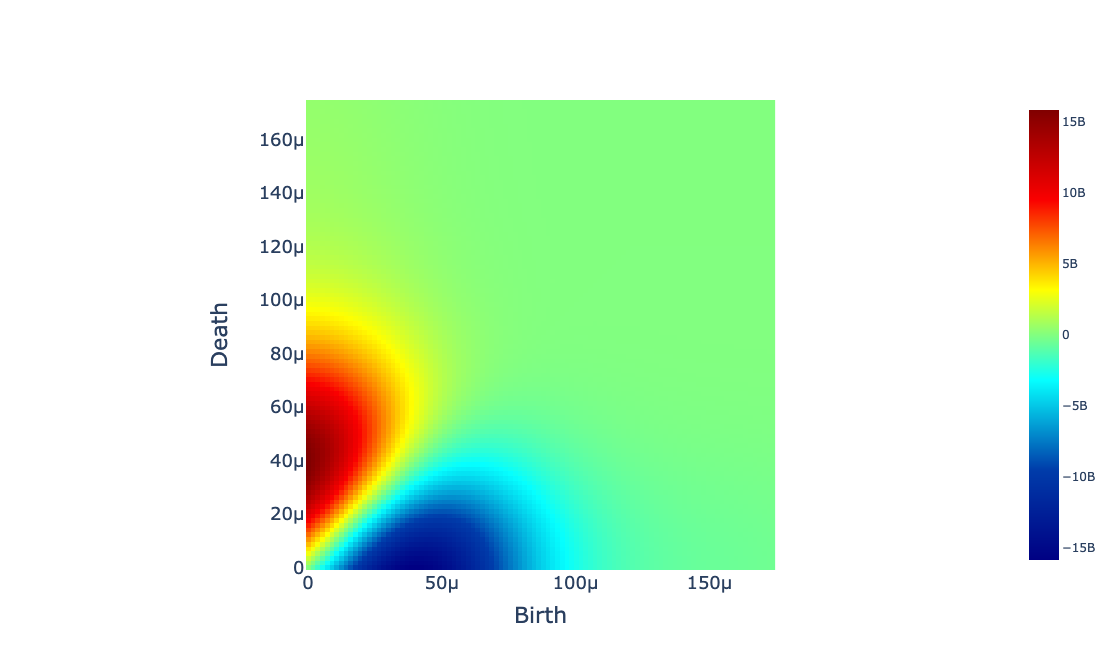

In [38]:
print("Heat kernel intensity of label " + str(label) + " for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

fig = HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
#pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 0 (Label " + str(label) + ").png")


Heat kernel intensity of label 1  for homology dimension 1: 794786559.068151


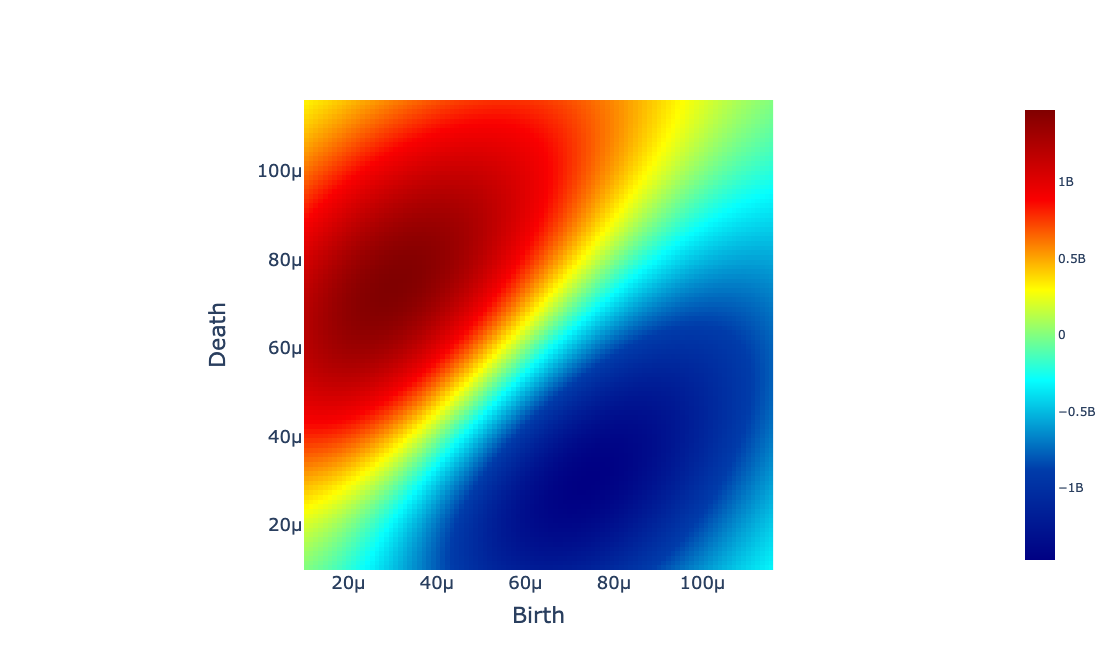

In [39]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 1: " + str(heat_kernel_intensity(heatkernel, 1)))


fig = HK.plot(heatkernel, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
#pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 1 (Label "+str(label)+").png")

Heat kernel intensity of label 0  for homology dimension 2: 0.5452464126434898


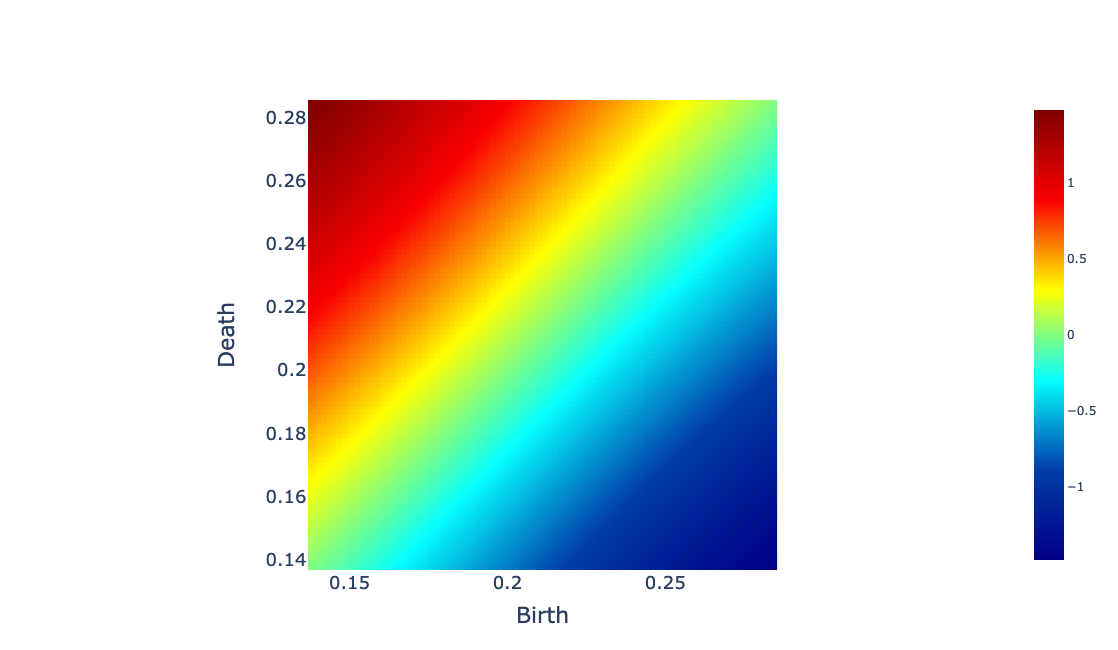

In [291]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 2: " + str(heat_kernel_intensity(heatkernel, 2)))


fig = HK.plot(heatkernel, homology_dimension_idx=2, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 2 (Label "+str(label)+").png")

# Persistence Landscape

In [292]:
PL = PersistenceLandscape()

In [305]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": False,  # Hide the legend
        "title": "", # Remove the title
        "height": 500,  # Set the desired height in pixels
        "margin": dict(l=150, r=50, t=50, b=100)  # Adjust margins if needed
    }
}


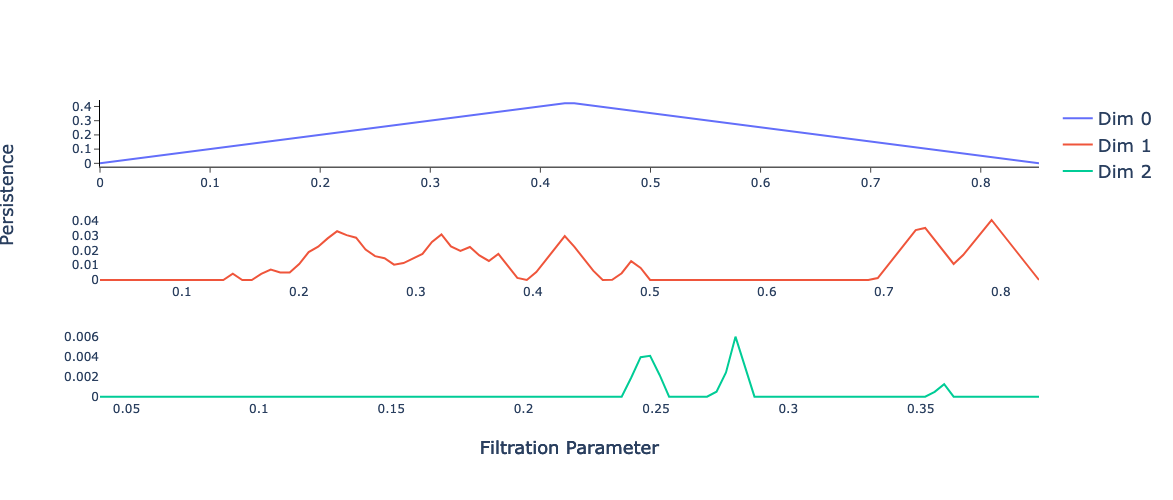

In [316]:
import plotly.io as pio

label = 4
landscape = PL.fit_transform(most_representative_diagrams[subject][data_type]["Label_" + str(label)])

# Generate the initial plot
fig = PL.plot(landscape, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"

# Update layout to add combined axis labels and increase legend font size
fig.update_layout(
    annotations=[
        dict(
            text="Filtration Parameter",
            x=0.5,
            y=-0.2,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=18)
        ),
        dict(
            text="Persistence",
            x=-0.1,
            y=0.5,
            xref="paper",
            yref="paper",
            showarrow=False,
            textangle=-90,
            font=dict(size=18)
        )
    ],
    margin=dict(l=100, r=20, t=100, b=100),  # Adjust margins if necessary
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Landscape_" + str(subject) + "_" + str(data_type) + "(Label " + str(label) + ").png")


# Silhouette

In [317]:
SH = Silhouette()

In [325]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": True,  # Hide the legend
        "title": "", # Remove the title
        "height": 300,  # Set the desired height in pixels
        "margin": dict(l=100, r=50, t=50, b=100),
        "xaxis": {
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Silhouette Value",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}


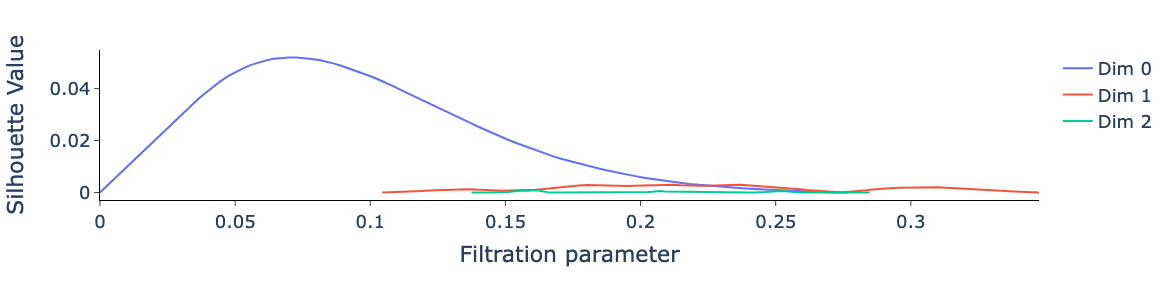

In [327]:
label = 0


silhouette = SH.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])


fig = SH.plot(silhouette, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"


fig.update_layout(
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)


# Update the layout to add combined axis labels

fig.show()


# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Silhouette_"+str(subject)+"_"+str(data_type)+"(Label "+str(label)+").png")

# Betti Curve

In [328]:
BC = BettiCurve()


In [329]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": True,  # Hide the legend
        "title": "", # Remove the title
        "height": 300,  # Set the desired height in pixels
        "margin": dict(l=100, r=50, t=50, b=100),
        "xaxis": {
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Betti Number",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}


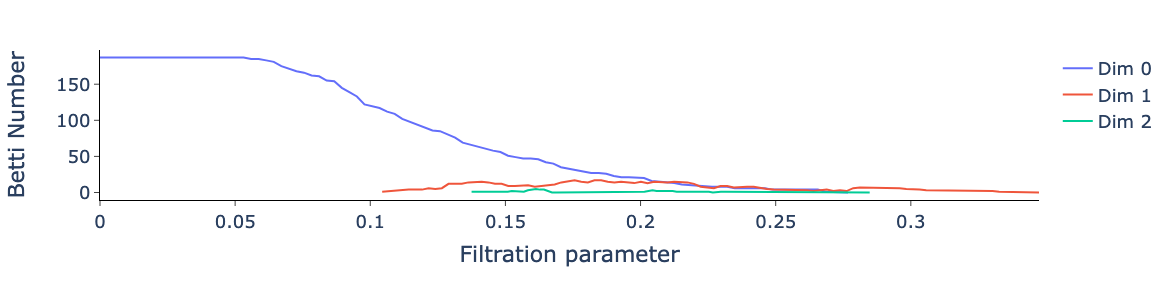

In [331]:
label = 0

betti_curve = BC.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])


fig = BC.plot(betti_curve, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"


fig.update_layout(
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)


# Update the layout to add combined axis labels

fig.show()


# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Betti_Curve_"+str(subject)+"_"+str(data_type)+"(Label "+str(label)+").png")

# Persistence Images

In [334]:
if data_type == "EEG":
    PI = PersistenceImage(sigma=0.2, n_bins=100)
elif data_type == "EMG":
    PI = PersistenceImage(sigma=0.003, n_bins=100)



In [335]:
# Parameters for plotting

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Center the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,
        "height": 650,
        "xaxis": {
            "title": "Birth",  # Add label for x-axis
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Death",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}

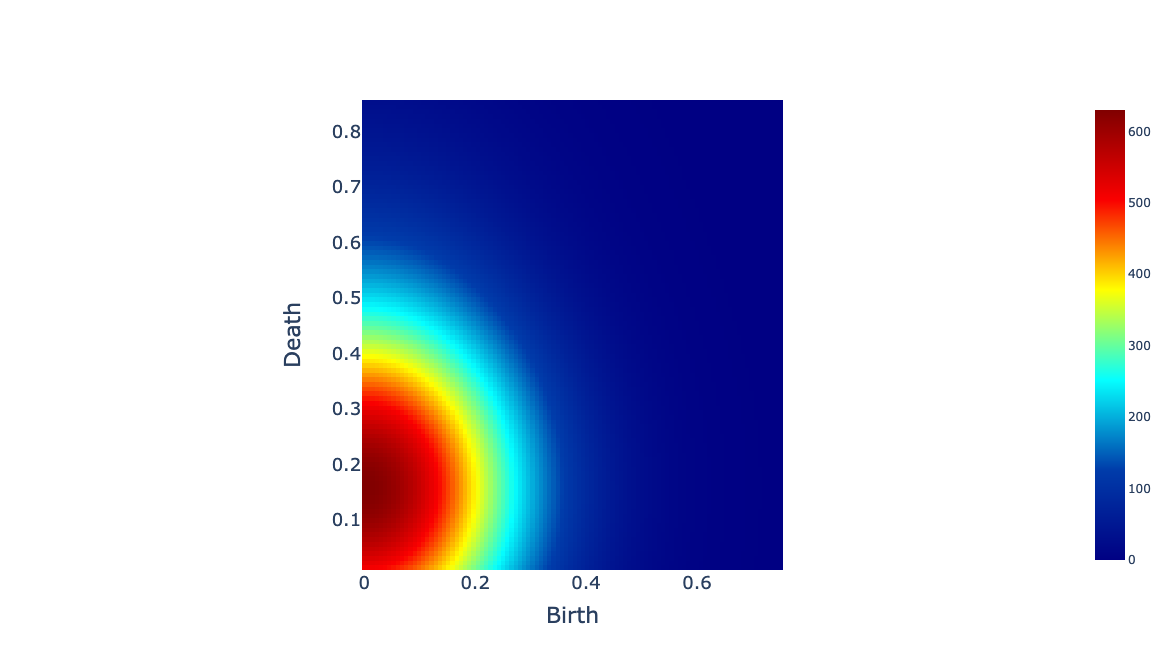

In [341]:
label = 4


persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 0 (Label " + str(label) + ").png")

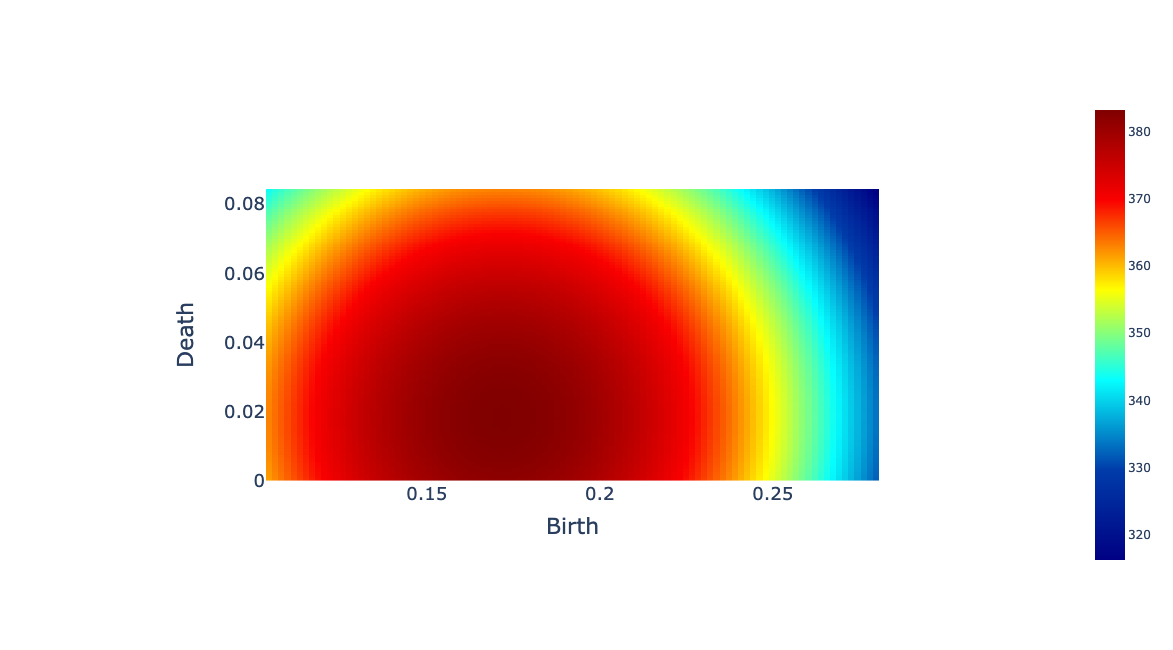

In [338]:
persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 1 (Label " + str(label) + ").png")

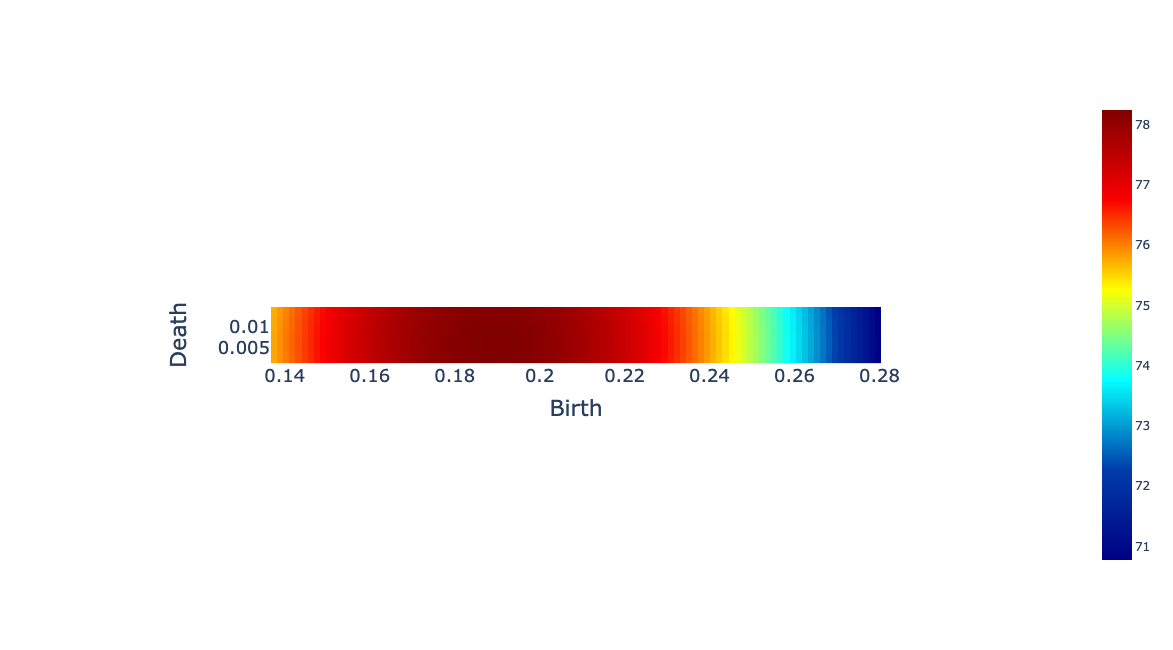

In [339]:
persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=2, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 2 (Label " + str(label) + ").png")

# Dimensionality reduced visualizations of Signature Vectorizations

First of all, combine all (extended persistence diagrams) to later examine the visualizations for clusters.

In [21]:
all_extended_diagrams = []

for label in label_list:
    all_extended_diagrams = all_extended_diagrams + extended_persistence_diagrams["Label_"+str(label)]

In [215]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing this for 3D plotting
import umap.umap_ as umap  # Correcting the import for UMAP

def separate_signature_according_to_dimension(signature):
    """
    Separate the landscape vectors according to each dimension.

    Parameters:
    - signature (list): Signature vector.

    Returns:
    - vectors (dict): Dictionary containing lists of vectors for each dimension.
    """
    vectors = {}
    
    for hom_dim in range(3):
        vectors["Dimension_" + str(hom_dim)] = []
        
        for vector_for_single_diagram in signature:
            vectors["Dimension_" + str(hom_dim)].append(vector_for_single_diagram[hom_dim])
    
    return vectors

def compute_umap_embedding(complete_data, data_list, homology_dimension, random_state=1):
    """
    Perform UMAP dimensionality reduction to 3 dimensions.

    Parameters:
    - signature (list): List containing the signature data.

    Returns:
    - embedding (numpy array): The 3-dimensional UMAP embedding.
    """
    # Perform UMAP dimensionality reduction to 3 dimensions


    reducer = umap.UMAP(n_components=3, random_state=random_state)
    
    reducer.fit(complete_data)
    
    embeddings = []

    for label in range(5):
        embeddings.append(reducer.transform(data_list["Label_"+str(label)]["Dimension_"+str(homology_dimension)]))
    
    return embeddings


def visualize_embedding(list_of_embeddings, title="Signature"):
    """
    Visualize two 3-dimensional UMAP embeddings in the same plot.

    Parameters:
    - list_of_embeddings (list): List of arrays with the first 3-dimensional UMAP embedding.
    - title (str): Title for the plot.

    Returns:
    None
    """
    # Visualize the embeddings
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plots for each label
    for i, embedding in enumerate(list_of_embeddings):
        ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=f'Label {i}', color=['blue', 'blueviolet', 'purple', 'crimson', 'red'][i])

    ax.set_xlabel('Dimension 1', fontsize=18)
    ax.set_ylabel('Dimension 2', fontsize=18)
    ax.set_zlabel('Dimension 3', fontsize=18)
    ax.set_title("")

    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=13)

    plt.savefig('Plots/'+str(title)+'.png', bbox_inches='tight')

    plt.show()



def compute_kernel_pca_embedding(complete_data, data_list, homology_dimension, kernel='rbf', n_components=3):
    """
    Compute a Kernel PCA reduced embedding with 3 dimensions.
    
    Parameters:
        data (numpy.ndarray): Input data matrix of shape (n_samples, n_features).
        kernel (str): Kernel function to be used ('rbf', 'poly', 'sigmoid', 'linear').
        n_components (int): Number of components for dimensionality reduction.
        
    Returns:
        numpy.ndarray: Kernel PCA reduced embedding of shape (n_samples, 3).
    """
    # Initialize Kernel PCA with specified kernel function
    kpca = KernelPCA(kernel=kernel, n_components=n_components, random_state=42)

    kpca.fit(complete_data[0][homology_dimension])
    
    # Fit and transform the data
    embeddings = []

    for label in range(5):
        embeddings.append(kpca.transform(data_list["Label_"+str(label)][0][homology_dimension]))
    
    return embeddings
    


## Betti Curve

In [197]:
BC = BettiCurve()

In [216]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = BC.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


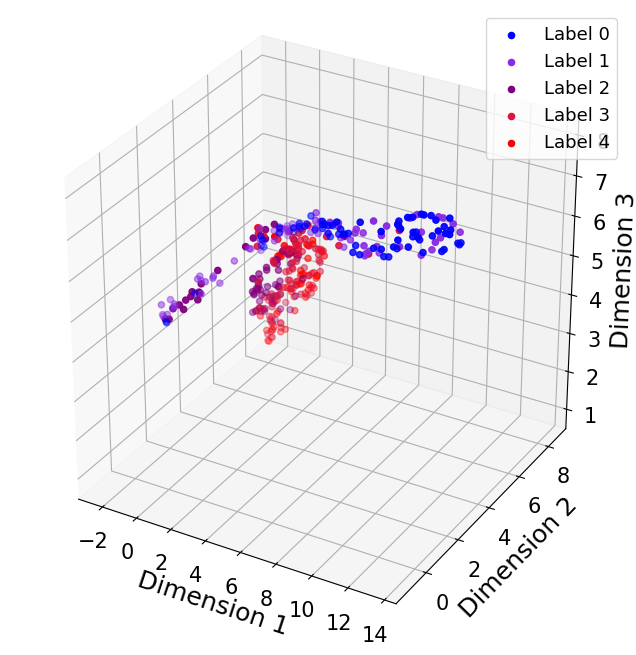

In [217]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


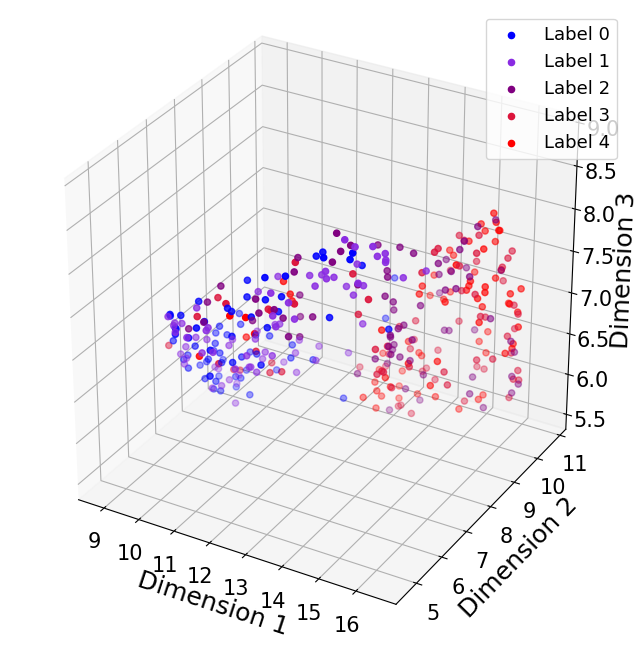

In [218]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


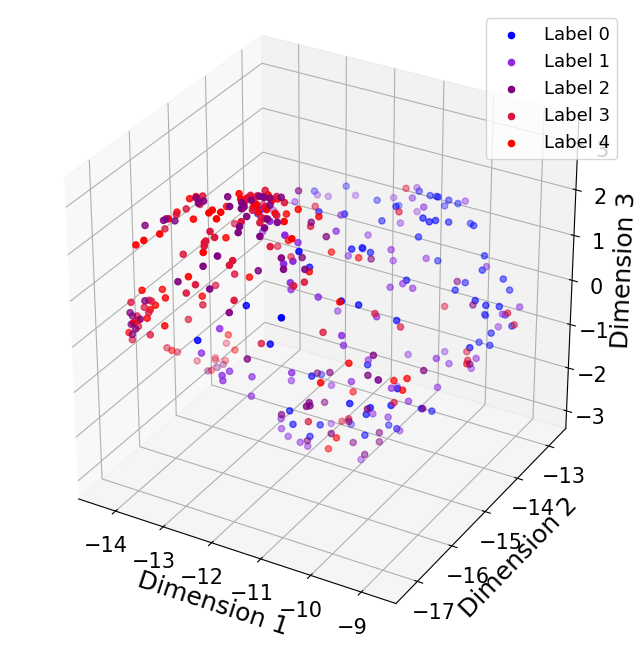

In [219]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


## Silhouette

In [220]:
SH = Silhouette()

In [221]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


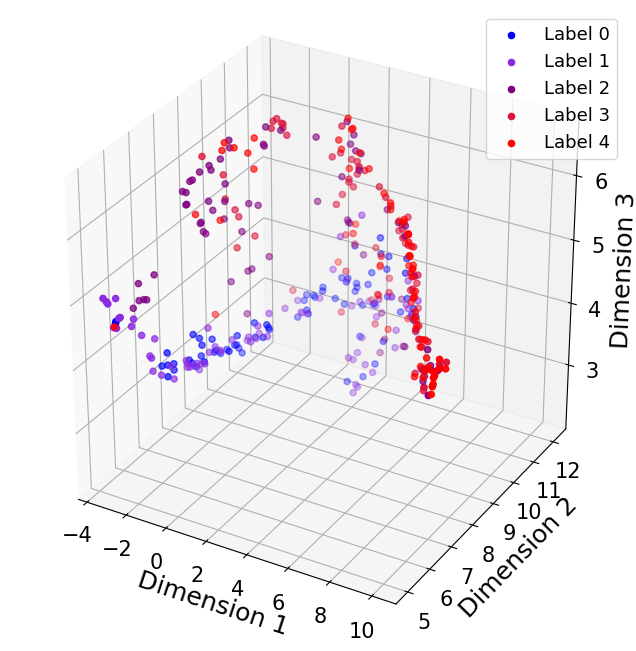

In [222]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


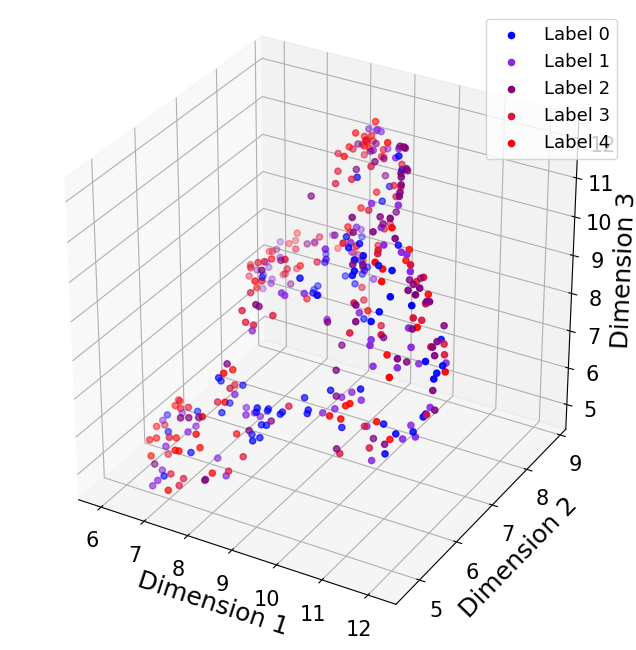

In [223]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


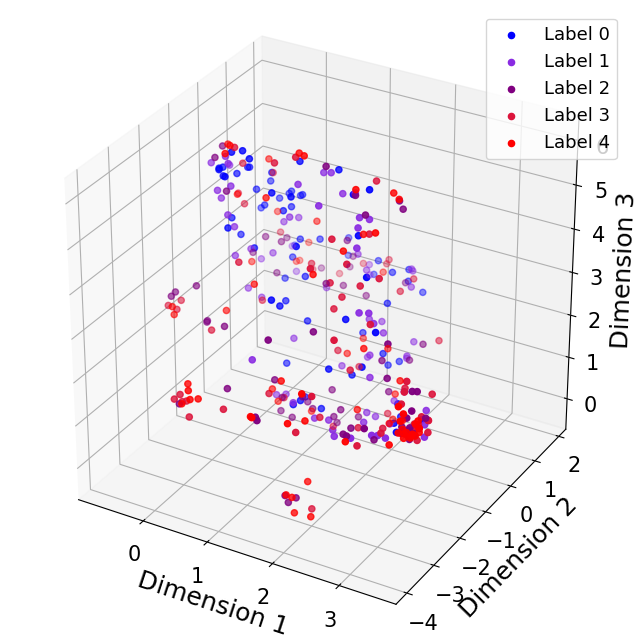

In [224]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


## Landscape

In [225]:
PL = PersistenceLandscape()

In [226]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = PL.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


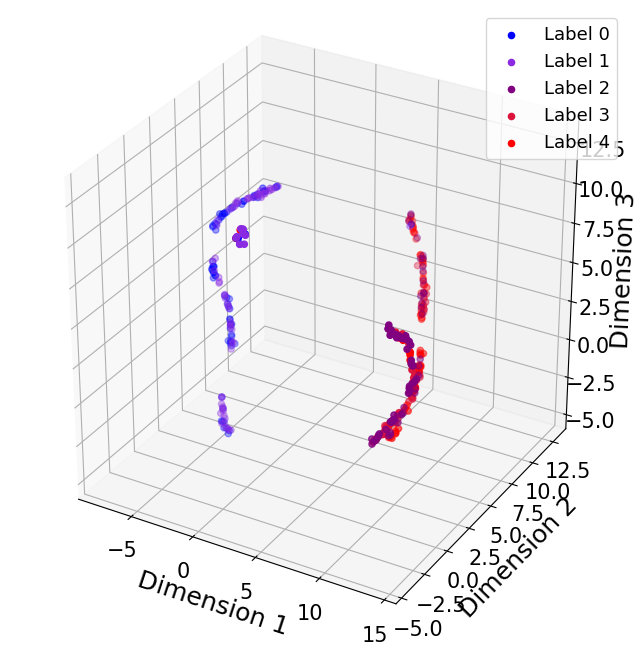

In [227]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


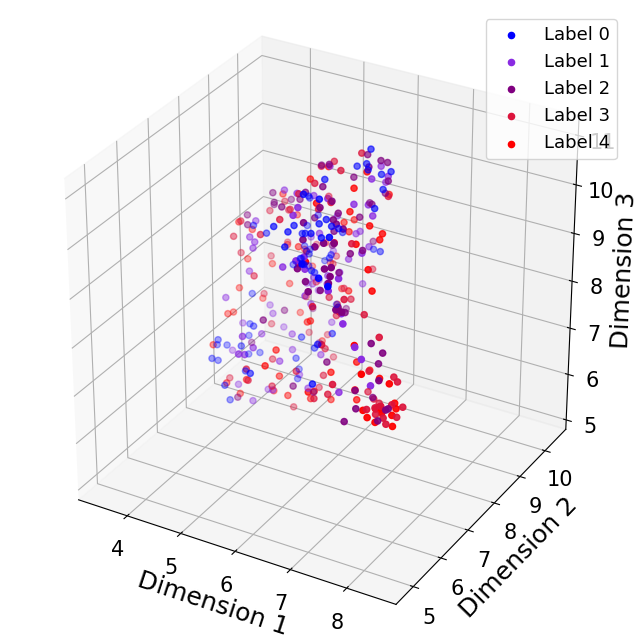

In [228]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


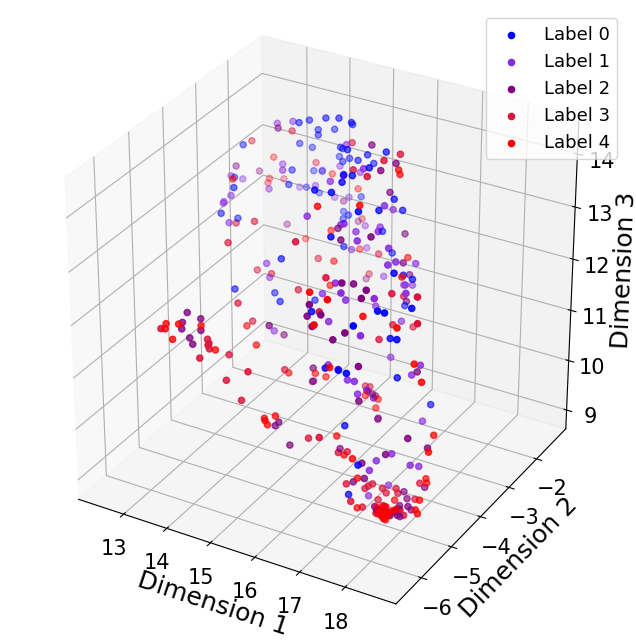

In [229]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))